In [2]:
# 1. Mount Google Drive to access your files
from google.colab import drive
drive.mount('/content/drive')

# 2. Install necessary libraries
!pip install pandas numpy scikit-learn matplotlib seaborn

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the file path in your Google Drive
file_path = '/content/drive/MyDrive/Lifesight/ML/data/Assessment_2_-_MMM_Weekly.csv'

# Load the dataset
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime objects and set as index
df['week'] = pd.to_datetime(df['week'])
df = df.set_index('week').sort_index()

print("Data Info:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104 entries, 2023-09-17 to 2025-09-07
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   facebook_spend    104 non-null    float64
 1   google_spend      104 non-null    float64
 2   tiktok_spend      104 non-null    float64
 3   instagram_spend   104 non-null    float64
 4   snapchat_spend    104 non-null    float64
 5   social_followers  104 non-null    int64  
 6   average_price     104 non-null    float64
 7   promotions        104 non-null    int64  
 8   emails_send       104 non-null    int64  
 9   sms_send          104 non-null    int64  
 10  revenue           104 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 9.8 KB
None

Descriptive Statistics:
       facebook_spend  google_spend  tiktok_spend  instagram_spend  \
count      104.000000    104.000000    104.000000       104.000000   
mean      5346.302500   1543.86644

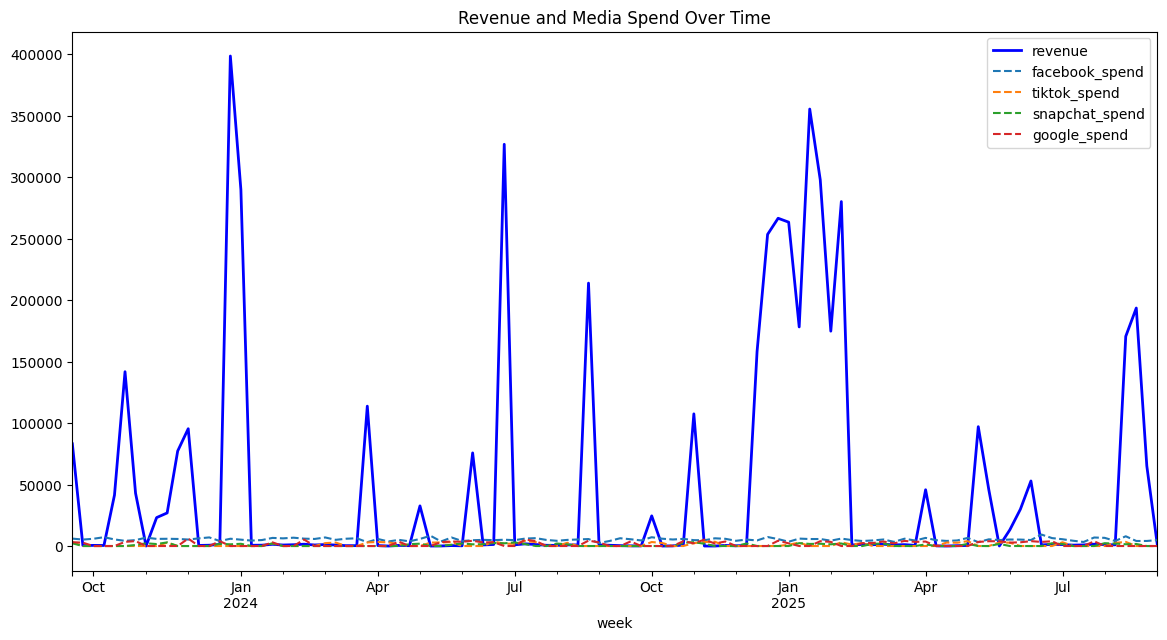

In [8]:
# Plot Revenue and Media Spends over time
fig, ax = plt.subplots(figsize=(14, 7))
df['revenue'].plot(ax=ax, label='revenue', lw=2, color='blue')
df[['facebook_spend', 'tiktok_spend', 'snapchat_spend', 'google_spend']].plot(ax=ax, linestyle='--')
ax.set_title('Revenue and Media Spend Over Time')
ax.legend()
plt.show()

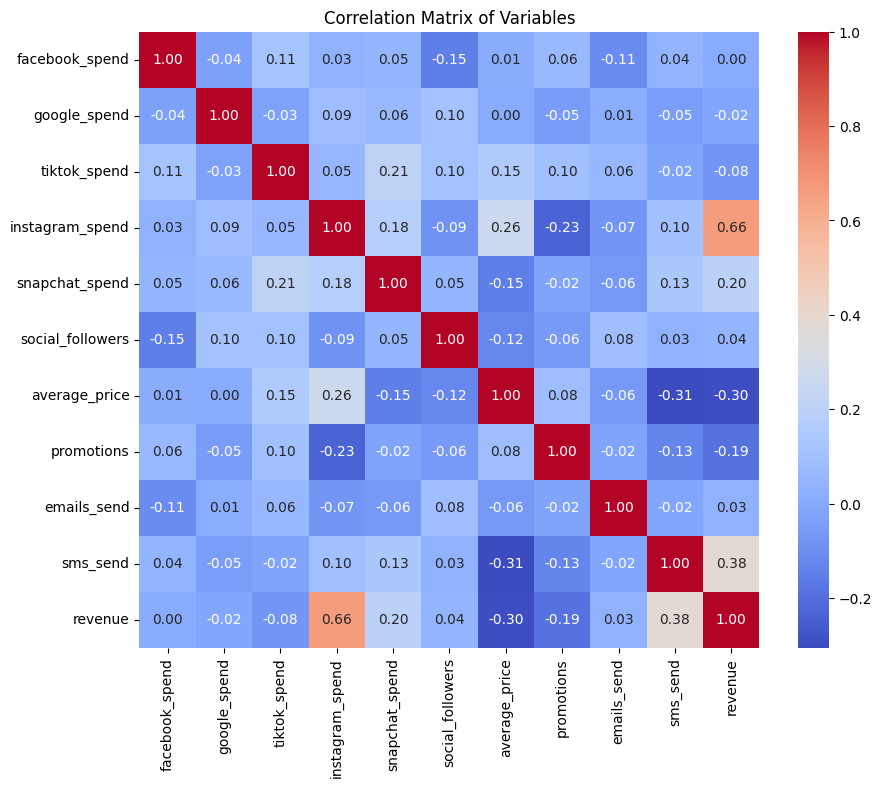

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()


In [13]:
# 1. Model Adstock (Carryover Effect)
def geometric_adstock(spend, decay_rate):
    """Calculates the geometric adstock of a spend series."""
    adstocked_spend = np.zeros_like(spend)
    adstocked_spend[0] = spend[0]
    for i in range(1, len(spend)):
        adstocked_spend[i] = spend[i] + decay_rate * adstocked_spend[i-1]
    return adstocked_spend

# --- UPDATED LIST ---
# Added 'instagram_spend' to the list of media channels
media_channels = ['facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']
decay_rate = 0.5

for channel in media_channels:
    df[f'{channel}_adstock'] = geometric_adstock(df[channel], decay_rate)

# 2. Model Diminishing Returns (Saturation)
def hill_saturation(x, ec, slope):
    """Applies the Hill function for saturation."""
    return 1 / (1 + (x / (ec + 1e-8))**-slope)

adstock_channels = [f'{c}_adstock' for c in media_channels]
for channel in adstock_channels:
    ec50 = df[channel].median()
    slope = 2

    if ec50 > 0:
        df[f'{channel}_saturated'] = hill_saturation(df[channel], ec=ec50, slope=slope)
    else:
        df[f'{channel}_saturated'] = 0

# 3. Add controls for Trend and Seasonality
df['time_index'] = np.arange(len(df))
df['week_of_year'] = df.index.isocalendar().week.astype(int)
df['sin_week'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['cos_week'] = np.cos(2 * np.pi * df['week_of_year'] / 52)

print("DataFrame with updated engineered features:")
print(df[['instagram_spend_adstock_saturated', 'time_index']].head())

DataFrame with updated engineered features:
            instagram_spend_adstock_saturated  time_index
week                                                     
2023-09-17                           0.663379           0
2023-09-24                           0.330062           1
2023-10-01                           0.109662           2
2023-10-08                           0.029872           3
2023-10-15                           0.867258           4


/tmp/ipython-input-126641686.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adstocked_spend[0] = spend[0]
/tmp/ipython-input-126641686.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adstocked_spend[i] = spend[i] + decay_rate * adstocked_spend[i-1]
/tmp/ipython-input-126641686.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adstocked_spend[0] = spend[0]
/tmp/ipython-input-126641686.py:7: FutureWarning: Series.__getitem_

In [14]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler

# --- Stage 1: Model the Mediator (Google Spend) ---
# We add Instagram here as it's a social channel that can influence search
X1 = df[['facebook_spend_adstock_saturated', 'tiktok_spend_adstock_saturated',
         'instagram_spend_adstock_saturated', # <-- ADDED
         'snapchat_spend_adstock_saturated',
         'time_index', 'sin_week', 'cos_week', 'promotions', 'social_followers']]
y1 = df['google_spend_adstock_saturated']

stage1_model = LinearRegression()
stage1_model.fit(X1, y1)
df['google_spend_predicted_saturated'] = stage1_model.predict(X1)

# --- Stage 2: Model the Outcome (Revenue) ---
# Add Instagram and separate email/SMS
X2 = df[['facebook_spend_adstock_saturated', 'tiktok_spend_adstock_saturated',
         'instagram_spend_adstock_saturated', # <-- ADDED
         'snapchat_spend_adstock_saturated',
         'google_spend_predicted_saturated',
         'emails_send', # <-- UPDATED
         'sms_send',    # <-- UPDATED
         'average_price', 'social_followers', 'promotions',
         'time_index', 'sin_week', 'cos_week']]
y2 = df['revenue']

# Scale features
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)

# Use RidgeCV to find the best regularization strength (alpha)
alphas = np.logspace(-3, 3, 100)
stage2_model = RidgeCV(alphas=alphas)
stage2_model.fit(X2_scaled, y2)

print(f"Optimal Alpha for Ridge Regression: {stage2_model.alpha_:.4f}")
print("\nCausal model has been successfully trained with updated variables.")

Optimal Alpha for Ridge Regression: 0.9326

Causal model has been successfully trained with updated variables.


In [15]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

# n_splits determines how many times we'll train and test the model
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []

# Loop through each split
for train_index, test_index in tscv.split(X2_scaled):
    X_train, X_test = X2_scaled[train_index], X2_scaled[test_index]
    y_train, y_test = y2.iloc[train_index], y2.iloc[test_index]

    # Fit a model on the training portion of the data
    # We use the same alpha we found earlier with RidgeCV
    model_fold = Ridge(alpha=stage2_model.alpha_)
    model_fold.fit(X_train, y_train)

    # Predict on the unseen test portion and calculate the error
    preds = model_fold.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    rmse_scores.append(rmse)

print(f"Rolling CV RMSE Scores: {rmse_scores}")
print(f"Average Rolling CV RMSE: {np.mean(rmse_scores):.2f}")

Rolling CV RMSE Scores: [np.float64(109508.13751869329), np.float64(139838.1282575481), np.float64(54526.36604729149), np.float64(74361.37380444401), np.float64(74799.94077820635)]
Average Rolling CV RMSE: 90606.79


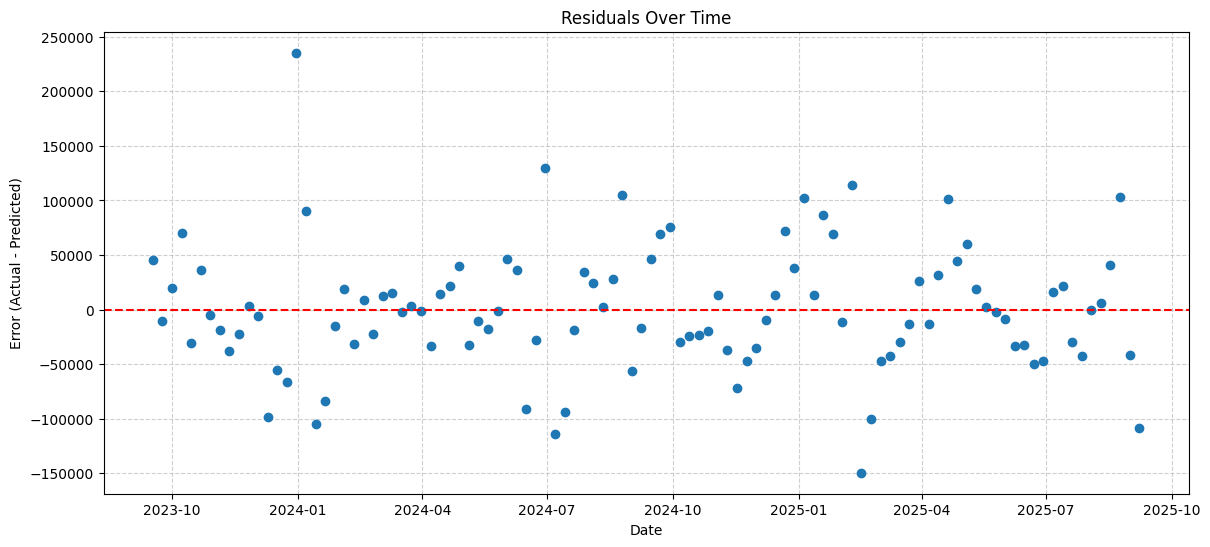

In [16]:
# Get predictions from the final model on the whole dataset
final_predictions = stage2_model.predict(X2_scaled)
residuals = y2 - final_predictions

# Plot residuals over time
plt.figure(figsize=(14, 6))
plt.plot(df.index, residuals, marker='o', linestyle='None')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Error (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

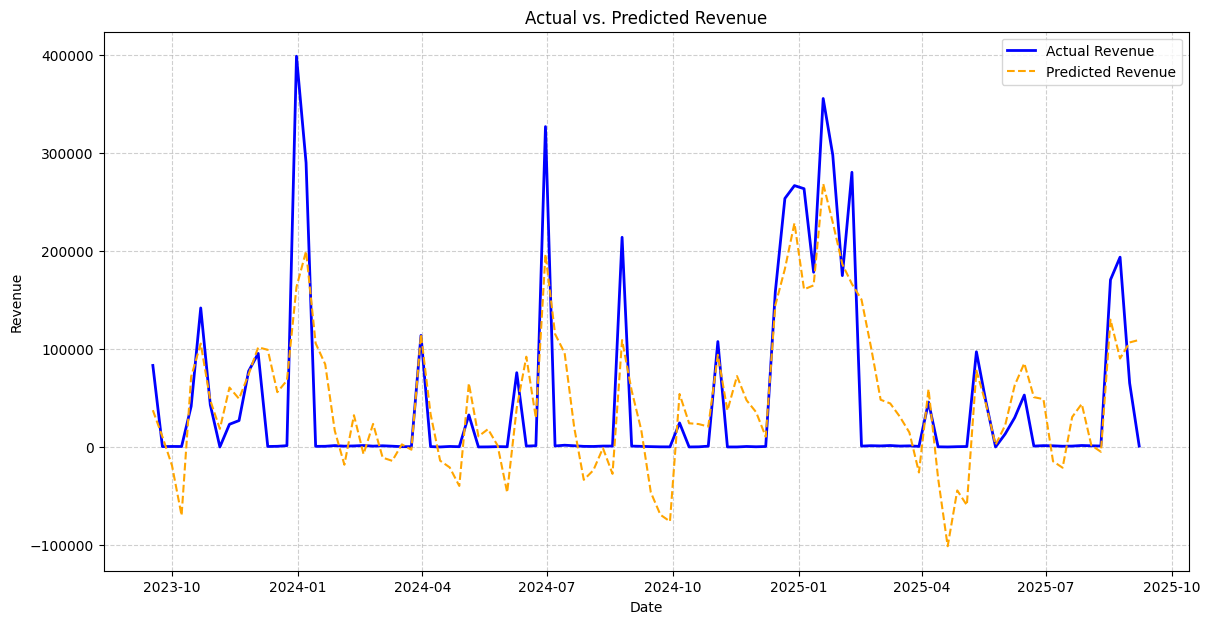

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, y2, label='Actual Revenue', color='blue', lw=2)
plt.plot(df.index, final_predictions, label='Predicted Revenue', color='orange', linestyle='--')
plt.title('Actual vs. Predicted Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [18]:
# Create a dataframe of the model's coefficients for easy interpretation
coefs = pd.DataFrame(
    data=stage2_model.coef_,
    index=X2.columns,
    columns=['Coefficient']
).sort_values(by='Coefficient', ascending=False)

print("Model Coefficients:")
print(coefs)

Model Coefficients:
                                    Coefficient
instagram_spend_adstock_saturated  45585.065649
cos_week                           36847.010054
social_followers                   33266.651529
google_spend_predicted_saturated   28186.853809
sms_send                           19454.646738
tiktok_spend_adstock_saturated     18530.306926
promotions                          4167.947664
facebook_spend_adstock_saturated    3554.769117
emails_send                        -3385.183752
sin_week                           -6873.290224
snapchat_spend_adstock_saturated  -14749.905049
time_index                        -31921.676500
average_price                     -38878.410984


In [19]:
# Calculate the total contribution of each variable to revenue
# This is done by multiplying the scaled feature value by its coefficient for each week
total_contribution = (pd.DataFrame(X2_scaled, columns=X2.columns) * stage2_model.coef_).sum()

# Get the original total spend for each channel to calculate ROI
total_spend = df[['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'google_spend']].sum()

# Create a summary DataFrame
# We'll map the contribution of the saturated adstock features to the original spend columns
roi_summary = pd.DataFrame({
    'Total Spend': total_spend,
    'Total Contribution': [
        total_contribution['facebook_spend_adstock_saturated'],
        total_contribution['tiktok_spend_adstock_saturated'],
        total_contribution['instagram_spend_adstock_saturated'],
        total_contribution['snapchat_spend_adstock_saturated'],
        # For Google, we use the contribution of the MEDIATED effect
        total_contribution['google_spend_predicted_saturated']
    ]
})

# ROI = (Contribution - Spend) / Spend is one way, but marketers often use Contribution / Spend
roi_summary['ROI'] = roi_summary['Total Contribution'] / roi_summary['Total Spend']

print("\nChannel Contribution and ROI Summary:")
print(roi_summary.sort_values(by='ROI', ascending=False))


Channel Contribution and ROI Summary:
                 Total Spend  Total Contribution           ROI
google_spend       160562.11        2.328306e-10  1.450097e-15
snapchat_spend      77736.36        7.639755e-11  9.827776e-16
facebook_spend     556015.46       -1.637090e-10 -2.944325e-16
tiktok_spend        99385.75       -8.185452e-11 -8.236042e-16
instagram_spend    106011.66       -3.783498e-10 -3.568945e-15
